In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX
using CSV
using Plots
gr(fmt=:png);

abstract type Model end
struct BEM <: Model end
struct Migration <: Model end

run = BEM();

In [2]:
df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM][5:end]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM][5:end]) ## PRICE DATA

### New max time
time = df2[:Year][5]:0.1:df2[:Year][end]; #df2[:Year][5:end]
years = df2[:Year][5:end];
tmax = length(df2[:Year][5:end]);
(Cmax, CmaxIdx) = findmax(VolAll); # To calculate K. Should probably self reference this.

In [3]:
Th(a,b,c,d,t) = a+b*t+c*cos.(t)+d*sin.(t);
ddTh(c,d,t) = -c*cos.(t)-d*sin.(t);
function getMinT(a,b,c,d)
    t = 2*atan((sqrt(-b^2+c^2+d^2)+c)/(b-d))-2005; #dTh == 0, solve t
    if ddTh(c,d,t) > 0
        Th(a,b,c,d,t)
    else
        Th(a,b,c,d,t+π)
    end
end
function getMaxT(a,b,c,d, t)
    #t = 2*atan(b/c)+2005;
    2*atan((sqrt(-b^2+c^2+d^2)+c)/(b-d))
    if ddTh(c,d,t) < 0
        Th(a,b,c,d,t)
    else
        Th(a,b,c,d,t+π)
    end
end
#function getK(a,b,c,Cmax,idx)
#    taul = getMinTau(a,b,c);
#    tauu = getMaxTau(a,b,c);
#    Cmax*0.1*((tauh(a,b,c,idx)-taul)/(tauu-taul))
#end

In [4]:
#Initial isotherm coefficient guesses
b0 = -16.49; #mean depth
b1 = 0.02; #trend
b2 = 6.779; #amplitude
b3 = 0.091; #period of seasonal cycles

q = 0.1*maximum(Th(b0, b1, b2, b3, time))
K = Cmax*q

f = 40.0 # l of fuel per trip
m = 5_492_603.58 # cost per unit of transport all boats, MXN/trip
σ = m*f; # fleet cost of transport

In [5]:
# Model with free effort
model = JuMP.Model(solver = IpoptSolver(max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(model, 0.0 <= β <= 1.0) # slope of demand-price function
@variable(model, 20_000.0 <= γₘ <= 51_000.0) # maximum demand, t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 1000.0 <= κ <= 2148.0) # cost of processing, MXNia/t

@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(model, 4_000.0 <= p_m[t=1:tmax] <= 100_000.0) # export/market price

@variable(model, match)

@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+(g*S[t]*(1-(S[t]/K))-C[t]));
@NLconstraint(model, [t=1:tmax], p_m[t] == γₘ*(C[t])^(-β));
@constraint(model, [t=1:tmax], p_f[t] == p_m[t]-κ);
@NLconstraint(model, [t=1:tmax], C[t] == q*E[t]*S[t]);

#@NLconstraint(model, [t=1:tmax-1], E[t+1] == E[t]+(p_f[t]*C[t]-σ*E[t]));

@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [6]:
solve(model)

This is Ipopt version 3.12.11, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      189
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      165

Total number of variables............................:       65
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       28
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

:Error

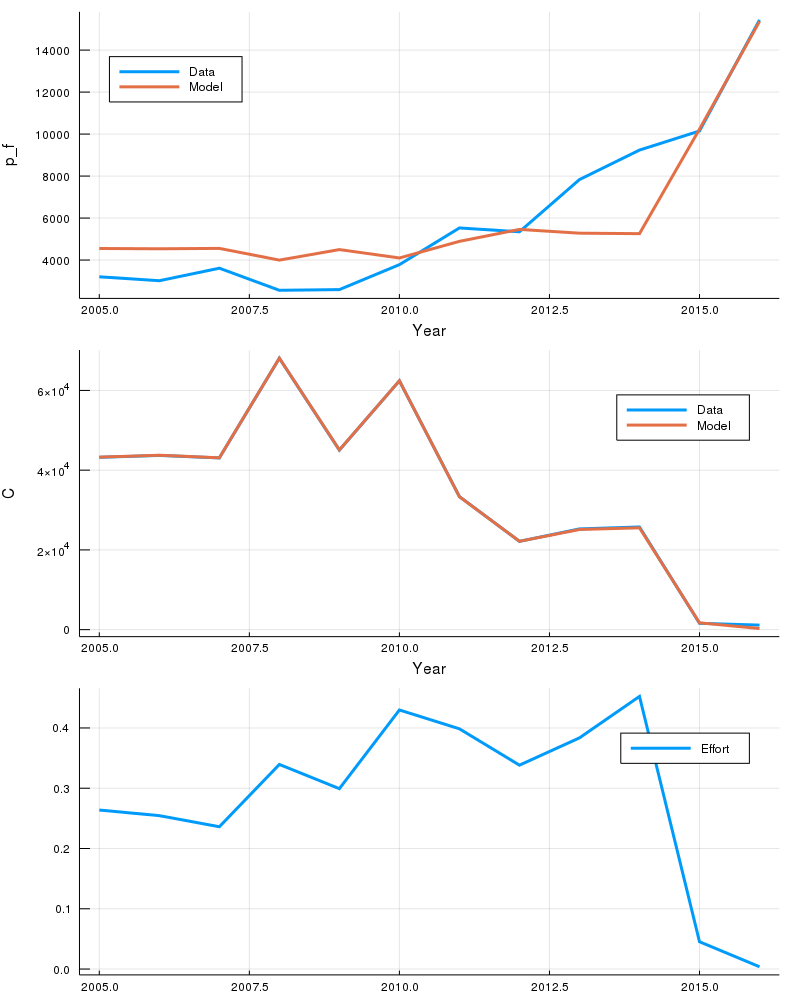

In [7]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_f), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(C), label="Model")
hc = plot(years, getvalue(E), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

In [8]:
# Model with effort scaling
modele = JuMP.Model(solver = IpoptSolver(max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modele, 0.0 <= βe <= 1.0) # slope of demand-price function
@variable(modele, 20_000.0 <= γₘe <= 51_000.0) # maximum demand, t
@variable(modele, 0.0 <= ge <= 3.2) # population growth rate
@variable(modele, 1000.0 <= κe <= 2148.0) # cost of processing, MXNia/t

@variable(modele, 0.0 <= Ee[t=1:tmax] <= 1.0) # fishing effort
@variable(modele, p_fe[t=1:tmax]) # price for fishers
@variable(modele, Se[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modele, Ce[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modele, 4_000.0 <= p_me[t=1:tmax] <= 100_000.0) # export/market price

@variable(modele, matche)

@NLconstraint(modele, [t=1:tmax-1], Se[t+1] == Se[t]+(ge*Se[t]*(1-(Se[t]/K))-Ce[t]));
@NLconstraint(modele, [t=1:tmax], p_me[t] == γₘe*(Ce[t])^(-βe));
@constraint(modele, [t=1:tmax], p_fe[t] == p_me[t]-κe);
@NLconstraint(modele, [t=1:tmax], Ce[t] == q*Ee[t]*Se[t]);
@NLconstraint(modele, [t=1:tmax-1], Ee[t+1] == Ee[t]+(p_fe[t]*Ce[t]-σ*Ee[t]));

@NLconstraint(modele, matche == sum(abs(p_fe[t] - PrAll[t])^2+abs(Ce[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modele, Min, matche);

In [9]:
solve(modele)

This is Ipopt version 3.12.11, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      233
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      198

Total number of variables............................:       65
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       28
                     variables with only upper bounds:        0
Total number of equality constraints.................:       59
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

:Optimal

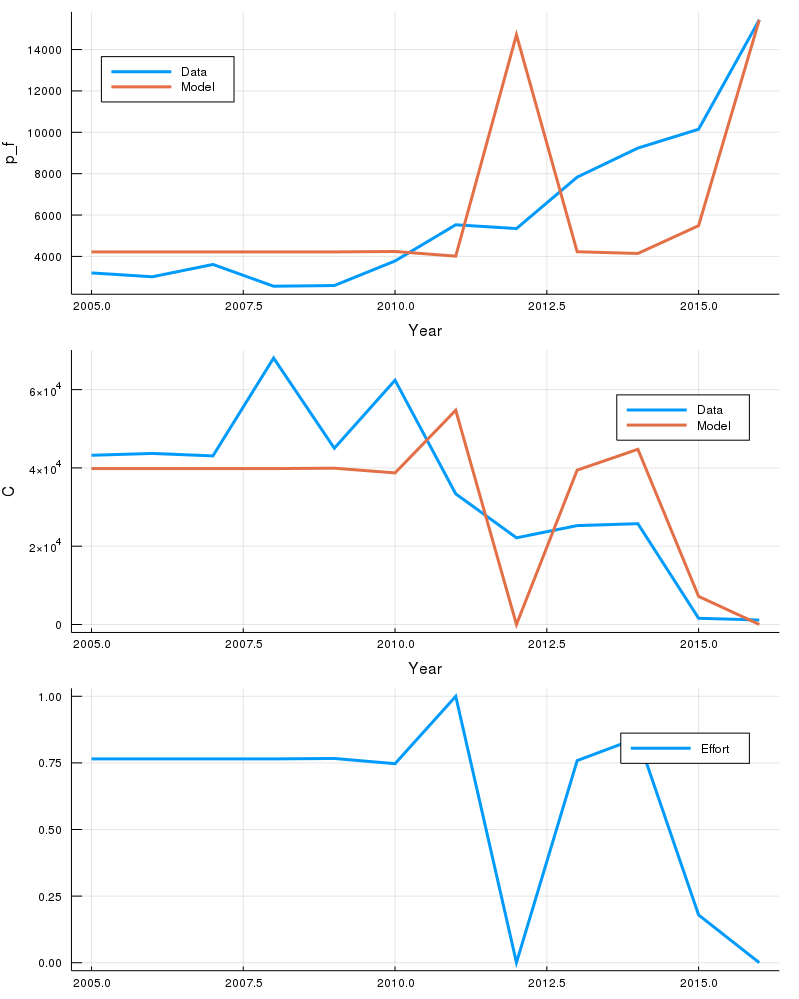

In [10]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fe), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Ce), label="Model")
hc = plot(years, getvalue(Ee), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

In [11]:
# Model with effort, no scaling
modeln = JuMP.Model(solver = IpoptSolver(max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modeln, 0.0 <= βn <= 1.0) # slope of demand-price function
@variable(modeln, 20_000.0 <= γₘn <= 51_000.0) # maximum demand, t
@variable(modeln, 0.0 <= gn <= 3.2) # population growth rate
@variable(modeln, 1000.0 <= κn <= 2148.0) # cost of processing, MXNia/t

@variable(modeln, En[t=1:tmax]) # fishing effort
@variable(modeln, p_fn[t=1:tmax]) # price for fishers
@variable(modeln, Sn[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modeln, Cn[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modeln, 4_000.0 <= p_mn[t=1:tmax] <= 100_000.0) # export/market price

@variable(modeln, matchn)

@NLconstraint(modeln, [t=1:tmax-1], Sn[t+1] == Sn[t]+(gn*Sn[t]*(1-(Sn[t]/K))-Cn[t]));
@NLconstraint(modeln, [t=1:tmax], p_mn[t] == γₘn*(Cn[t])^(-βn));
@constraint(modeln, [t=1:tmax], p_fn[t] == p_mn[t]-κn);
@NLconstraint(modeln, [t=1:tmax], Cn[t] == q*En[t]*Sn[t]);
@NLconstraint(modeln, [t=1:tmax-1], En[t+1] == En[t]+(p_fn[t]*Cn[t]-σ*En[t]));

@NLconstraint(modeln, matchn == sum(abs(p_fn[t] - PrAll[t])^2+abs(Cn[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modeln, Min, matchn);

In [12]:
solve(modeln)

This is Ipopt version 3.12.11, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      233
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      198

Total number of variables............................:       65
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       16
                     variables with only upper bounds:        0
Total number of equality constraints.................:       59
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

:Optimal

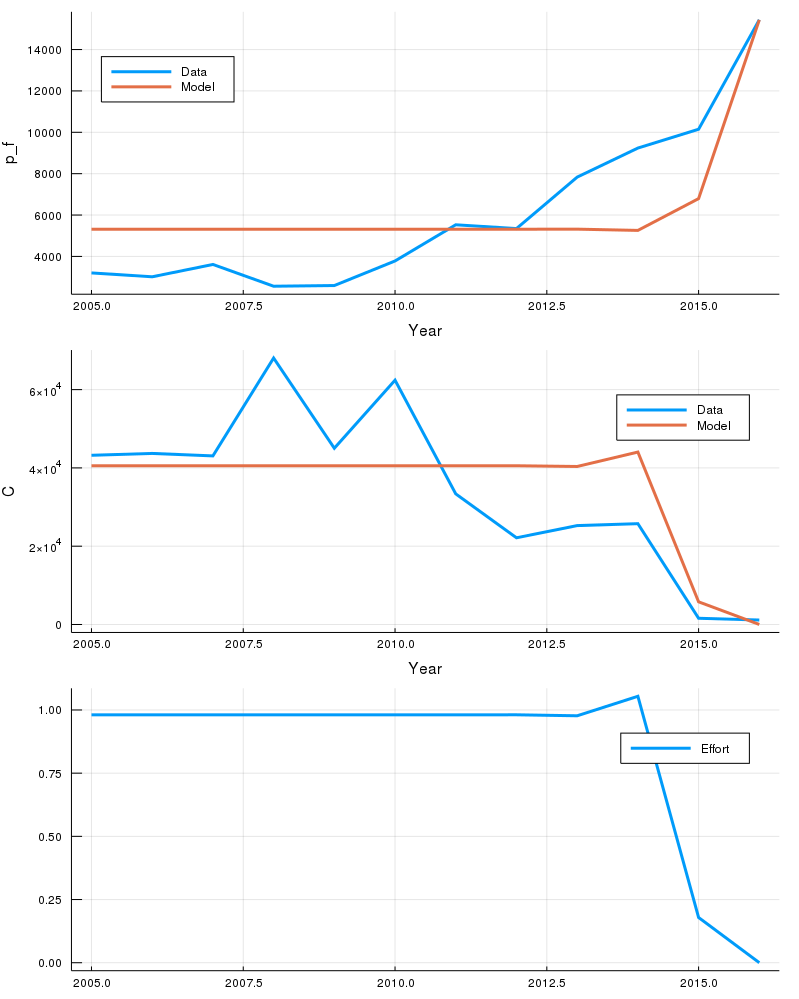

In [13]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fn), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Cn), label="Model")
hc = plot(years, getvalue(En), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

# Let's take the parameters from the initial run and plot E based on the captured parameters

In [14]:
struct OptimalConstants
    β::Float64
    γ::Float64
    g::Float64
    κ::Float64
    E₀::Float64
    S₀::Float64
end

# Using initial optimal
r = OptimalConstants(getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), getvalue(E)[1], getvalue(S)[1]);

# Discrete initially
Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
   
    Cd[t+1] = q*getvalue(E)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

# Total fail
Ed

12-element Array{Float64,1}:
  0.26381   
  1.38908e8 
 -3.05186e16
  6.70507e24
 -1.47313e33
  3.23653e41
 -7.11079e49
  1.56227e58
 -3.43237e66
  7.54106e74
 -1.6568e83 
  3.64007e91

In [15]:
# Scaled
r = OptimalConstants(getvalue(βe), getvalue(γₘe), getvalue(ge), getvalue(κe), getvalue(Ee)[1], getvalue(Se)[1]);

Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
    
    Cd[t+1] = q*getvalue(Ee)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

# Total fail
Ed

12-element Array{Float64,1}:
  0.765079  
  2.44599   
 -3.69304e8 
  8.11375e16
 -1.78263e25
  3.9165e33 
 -8.60472e41
  1.89049e50
 -4.15349e58
  9.12539e66
 -2.00489e75
  4.40482e83

In [16]:
#Not scaled

r = OptimalConstants(getvalue(βn), getvalue(γₘn), getvalue(gn), getvalue(κn), getvalue(En)[1], getvalue(Sn)[1]);

Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
    
    Cd[t+1] = q*getvalue(En)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

#Total Fail
Ed

12-element Array{Float64,1}:
  0.980743  
  4.87707   
 -8.56038e8 
  1.88075e17
 -4.13209e25
  9.07837e33
 -1.99456e42
  4.38212e50
 -9.6277e58 
  2.11525e67
 -4.64728e75
  1.02103e84

In [17]:
log.(Ed-minimum(Ed))

12-element Array{Float64,1}:
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
  174.23 
 -Inf    
  193.438

Effort just doesn't seem feasible in this form at all. How is this the 'standard' model for this form of data?

---

Let's try a continuous method.

In [18]:
using DifferentialEquations
# To work with optimal E
using Interpolations

In [19]:
# Using initial optimal, trying to use E and failing
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[3] - du[1] # S
  out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[3] = p[7]*u[2]*u[1] - u[3] # C
  out[4] = p[2]*u[3]^(-p[1]) - u[4] # p_m
  out[5] = u[4]-p[4] - u[5] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*E₀*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, E₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

DiffEqBase.DAEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (2005.0, 2016.0)
u0: [53773.3, 0.26381, 43264.3, 6698.36, 4550.36]
du0: [0.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
# Using initial optimal, using interpolated optimal E
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

Econt = interpolate((years,), getvalue(E), Gridded(Linear()));

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[2] - du[1] # S
  #out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[2] = p[7]*Econt(t)*u[1] - u[2] # C
  out[3] = p[2]*u[2]^(-p[1]) - u[3] # p_m
  out[4] = u[3]-p[4] - u[4] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
#E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*Econt(years[1])*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

DiffEqBase.DAEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (2005.0, 2016.0)
u0: [53773.3, 43264.3, 6698.36, 4550.36]
du0: [0.0, 0.0, 0.0, 0.0]

In [21]:
sol = DifferentialEquations.solve(prob,IDA())

retcode: Success
Interpolation: 3rd order Hermite
t: 143-element Array{Float64,1}:
 2005.0 
 2005.01
 2005.02
 2005.04
 2005.09
 2005.18
 2005.35
 2005.7 
 2006.0 
 2006.06
 2006.18
 2006.3 
 2006.42
    ⋮   
 2015.18
 2015.28
 2015.37
 2015.46
 2015.55
 2015.64
 2015.74
 2015.83
 2015.89
 2015.95
 2015.98
 2016.0 
u: 143-element Array{Array{Float64,1},1}:
 [53773.3, 43264.3, 6698.36, 4550.36]
 [53801.8, 43270.4, 6698.18, 4550.18]
 [53830.4, 43276.6, 6698.0, 4550.0]  
 [53887.9, 43289.1, 6697.63, 4549.63]
 [54004.2, 43315.1, 6696.87, 4548.87]
 [54241.7, 43369.9, 6695.25, 4547.25]
 [54736.2, 43491.7, 6691.69, 4543.69]
 [55800.8, 43779.6, 6683.29, 4535.29]
 [56785.2, 44062.7, 6675.11, 4527.11]
 [56993.4, 44033.2, 6675.96, 4527.96]
 [57434.3, 43988.8, 6677.24, 4529.24]
 [57919.5, 43972.2, 6677.72, 4529.72]
 [58431.2, 43967.5, 6677.85, 4529.85]
 ⋮                                   
 [29499.7, 3388.01, 10872.3, 8724.27]
 [31971.2, 3298.61, 10927.7, 8779.68]
 [34640.9, 3169.79, 11010.6, 8862

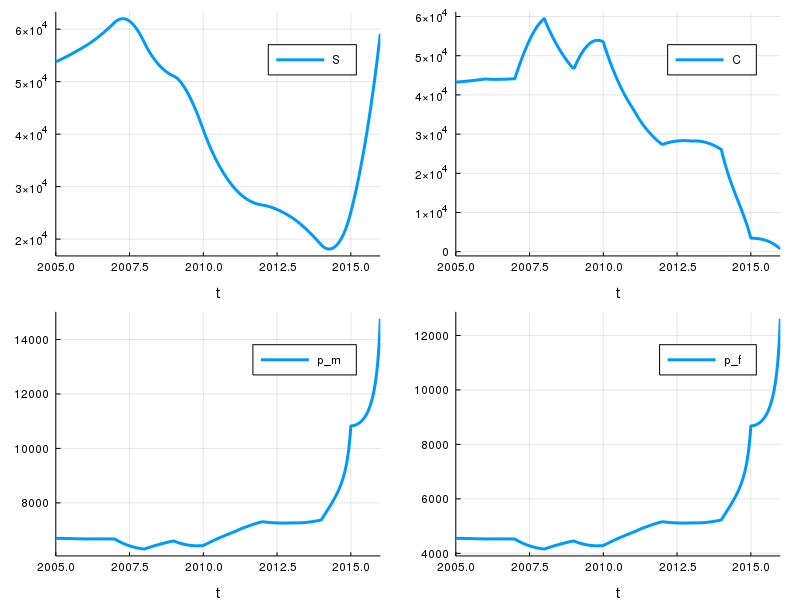

In [22]:
plot(sol, layout=(2,2), size=(800,600), label = ["S" "C" "p_m" "p_f"])